In [1]:
!pip install tensorflow tensorflow-datasets


In [2]:
import tensorflow_datasets as tfds

dataset = tfds.load("eurosat", split="train", as_supervised=True)


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt

IMG_SIZE = 256
NUM_CLASSES = 3


In [7]:
def data_generator(split="train", batch_size=8):
    image_paths = sorted(glob.glob(f"eurosat256/{split}/images/*.jpg"))
    label_paths = sorted(glob.glob(f"eurosat256/{split}/labels/*.txt"))

    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_imgs = []
            batch_masks = []

            for img_path, lab_path in zip(
                image_paths[i:i+batch_size],
                label_paths[i:i+batch_size]
            ):
                # ---------- Imagen ----------
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype("float32") / 255.0

                # ---------- Etiqueta ----------
                with open(lab_path) as f:
                    label = int(f.read().strip()) - 1  # 0,1,2

                # Máscara 256x256 con el valor de la clase
                mask = np.full((IMG_SIZE, IMG_SIZE), label, dtype=np.uint8)

                # Convertir a one-hot: (256,256,3)
                mask_onehot = tf.keras.utils.to_categorical(mask, NUM_CLASSES)

                batch_imgs.append(img)
                batch_masks.append(mask_onehot)

            yield np.array(batch_imgs), np.array(batch_masks)


In [8]:
batch_size = 32

train_gen = data_generator("train", batch_size)
val_gen   = data_generator("val", batch_size)

train_steps = len(glob.glob("eurosat256/train/images/*.jpg")) // batch_size
val_steps   = len(glob.glob("eurosat256/val/images/*.jpg"))   // batch_size

train_steps, val_steps


(675, 168)

In [9]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet():
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    b = conv_block(p3, 256)

    d3 = decoder_block(b, s3, 128)
    d2 = decoder_block(d3, s2, 64)
    d1 = decoder_block(d2, s1, 32)

    outputs = layers.Conv2D(NUM_CLASSES, 1, activation="softmax")(d1)

    return models.Model(inputs, outputs)

model = build_unet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_21[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 384)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    442,496 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_24[0][0] 

 Total params: 1,946,947 (7.43 MB)

 Trainable params: 1,946,947 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=20
)


Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 444s 570ms/step - accuracy: 0.5385 - loss: 0.9223 - val_accuracy: 0.7480 - val_loss: 0.6366
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 380s 563ms/step - accuracy: 0.7485 - loss: 0.6259 - val_accuracy: 0.7777 - val_loss: 0.5682
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 371s 549ms/step - accuracy: 0.7728 - loss: 0.5762 - val_accuracy: 0.7823 - val_loss: 0.5499
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 369s 547ms/step - accuracy: 0.7868 - loss: 0.5469 - val_accuracy: 0.8020 - val_loss: 0.5171
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 369s 547ms/step - accuracy: 0.8083 - loss: 0.5115 - val_accuracy: 0.8210 - val_loss: 0.4801
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 369s 547ms/step - accuracy: 0.8231 - loss: 0.4806 - val_accuracy: 0.8264 - val_loss: 0.4941
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 368s 546ms/step - accuracy: 0.8300 - loss: 0.4684 - val_accuracy: 0.8441 - val_loss: 0.4401
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 368s 546ms/step - accuracy: 0.8373 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


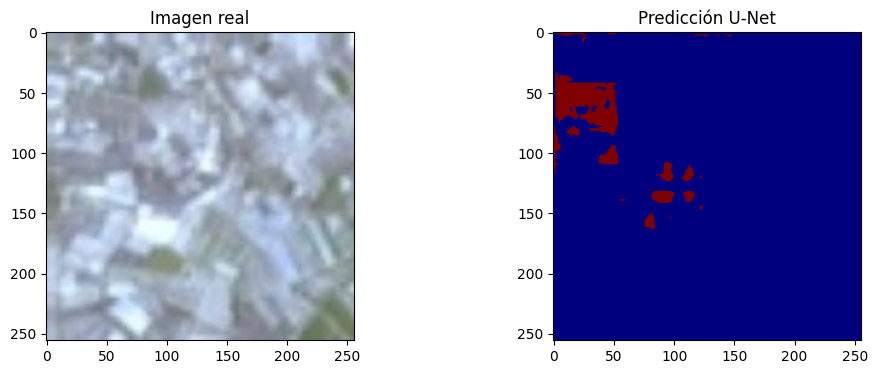

In [15]:
x_batch, y_batch = next(val_gen)
pred = model.predict(x_batch[0][np.newaxis, ...])[0]
pred_mask = np.argmax(pred, axis=-1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Imagen real")
plt.imshow(x_batch[0])

plt.subplot(1,2,2)
plt.title("Predicción U-Net")
plt.imshow(pred_mask, cmap="jet")
plt.show()


In [13]:
model.save("unet_eurosat.h5")


In [14]:
model.save("unet_eurosat.keras")
